README -- Out of memory errors <br>
This code is tuned for a RTX3060 12GB, if you have less memory, you will likely get "out of memory" errors with this code, try to aggressively reduce batch size (you can increase epochs to compensate)

### A Parallel Approach to Sequence Modeling

By leveraging the sequence length as a batch dimension, applying a linear layer to all embeddings on the GPU becomes highly efficient. In the attention mechanism, this process is repeated three times, yielding: 

**Keys**, **Queries**, **Values** -- Each of these has the shape `(batch_size, sequence_length, embedding_size)`.

We then multiply the keys and queries (transposed), resulting in a similarity matrix of size `(batch_size, sequence_length, sequence_length)`. This matrix indicates how much each token attends to (or is interested in) every other token. Subsequently, we multiply this matrix by the values and sum the results.

The core idea is that by constructing a similarity matrix, we can identify dependencies and use the values to update words with their new semantic meanings. For example, the word "apple" can refer to both a fruit and a technology company, the attention mechanism allows its meaning to be inferred from other words.

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import LucaM185 
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")

In [75]:
with open("datasets/enwik8", "r") as f:
    load = f.read()
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [76]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [77]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

99757179


Millions of parameters: 0.11
Epoch ___0 - Loss: 5.547 - Val Loss: 5.541
Epoch _300 - Loss: 3.117 - Val Loss: 3.105
Epoch _600 - Loss: 2.747 - Val Loss: 2.746
Epoch _900 - Loss: 2.465 - Val Loss: 2.626
Epoch 1200 - Loss: 2.389 - Val Loss: 2.369
Epoch 1500 - Loss: 2.287 - Val Loss: 2.184
Epoch 1800 - Loss: 2.244 - Val Loss: 2.439
Epoch 2100 - Loss: 2.193 - Val Loss: 2.174
Epoch 2400 - Loss: 2.115 - Val Loss: 2.070
Epoch 2700 - Loss: 2.090 - Val Loss: 2.149


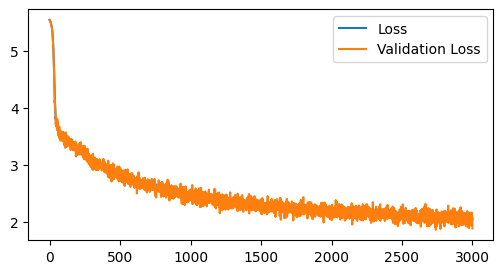

In [78]:
class Model(nn.Module):
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.fc_in = nn.Linear(emb_size*sequence_length, hidden_size)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)]) # this is a list of linear layers
        self.fc_out = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        emb = self.embeddings(inputs).view(inputs.shape[0], -1)
        x = F.gelu(self.fc_in(emb))
        for hidden in self.fc_hidden:    # iterating over hidden layers
            x = F.gelu(hidden(x))  # applying each hidden layer
        return self.fc_out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
model = Model(emb_size=16, hidden_size=128, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 3000
batch_size = 4096
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # 3e-4 is a good learning rate for Adam on big models

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) 
    loss = F.cross_entropy(pred, labels[indexes][:, -1].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        vloss = F.cross_entropy(pred, val_labels[indexes][:, -1].to(device))
        vlossi.append(vloss.item())
        
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")
    

plt.figure(figsize=(6, 3))  
plt.plot(lossi, label='Loss')
plt.plot(vlossi, label='Validation Loss')
plt.legend()

Limiting our dataset to ascii characters only reduces the size by 0.3% so we should be fine

# Attention Block - Scaled dot product attention

Scaled Dot-Product Attention allows a model to focus on different parts of an input sentence by comparing each word to every other word. It works by turning the input sentence into three types of information: **queries (Q)**, **keys (K)**, and **values (V)**, which are all derived from the same sentence. The queries and keys are compared to see which words are most relevant to each other. 

The model then calculates how much attention each word should give to others, based on these comparisons. To make sure the calculations are stable, we scale the comparisons and then turn them into probabilities. The result is a weighted sum of the values, which helps the model focus on the most important parts of the sentence.

This method compares every word with every other word, so it can become slow as the sentence gets longer, requiring more calculations. Actually if we want to use the better way of predicting tokens at each timestep from the RNN, we need to make sure that in the attention mechanism, past tokens can't get information from future ones, we do this by zeroing out the values with a tril matrix like this:


```
[ 1,  0,  0,  0 ]
[ 1,  1,  0,  0 ]
[ 1,  1,  1,  0 ]
[ 1,  1,  1,  1 ]
```


In [79]:
class Attention(nn.Module):  
    def __init__(self, emb_size, head_size):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)
        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)

        # By masking the attention we make sure that current tokens can't see future tokens, this allows us to train
        # the model with the entire sequence instead of a single token at a time. We call this "casual" attention
        similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = -1)

        attention = similarity @ v 
        attention = self.rvalues(attention)
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x


class Wrapper(nn.Module): 
    def __init__(self, vocab_size, emb_size, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

        self.fcout = nn.Linear(emb_size, vocab_size)

    def forward(self, x):          
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) 
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
        x = self.fcout(x)
    
        return x


Millions of parameters: 0.07
Epoch ___0 - Loss: 5.905 - Val Loss: 5.880
Epoch _600 - Loss: 2.688 - Val Loss: 2.739
Epoch 1200 - Loss: 2.517 - Val Loss: 2.569
Epoch 1800 - Loss: 2.440 - Val Loss: 2.416
Epoch 2400 - Loss: 2.367 - Val Loss: 2.361
Epoch 3000 - Loss: 2.361 - Val Loss: 2.202
Epoch 3600 - Loss: 2.260 - Val Loss: 2.285
Epoch 4200 - Loss: 2.275 - Val Loss: 2.257
Epoch 4800 - Loss: 2.264 - Val Loss: 2.262
Epoch 5400 - Loss: 2.200 - Val Loss: 2.188


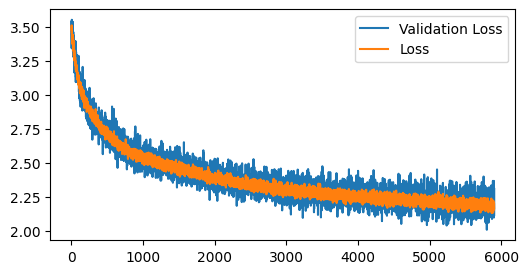

In [80]:
model = Wrapper(vocab_size=vocab_size, emb_size=128, head_size=128, hidden_size=128, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 512
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))

        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")
    
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

This performance is slightly worse than 20 layers MLP, but we are using just a single block (attention + 2 hidden layer MLP)  <br>
Note: we are using roughly 20k parameters instead of 370k

In [81]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")


           
KING RICHARD ICC nomith inachugthere:Dionva:, sple===
Nuppesor Qaglls Second regives.. Ame/surst dayl losimand-Bere dingly abvisin the that nots sulspartalle>Firisto folo, heer inshance stria [[mainstallor:>
:[[EUninest and and sopeckulane'sby:2425-6537]].

The Rerleld decams rend [[htttmon Englikies.

The Brigun

# Transformers 

Transformers consist of many attention blocks and MLPs in sequence, with residual connections 

In [82]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = x + (self.att(self.prenorm1(x)))
        x = x + (self.fc(self.prenorm2(x)))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = (self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))) 

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x


Millions of parameters: 0.35
Epoch ___0 - Loss: 5.746 - Val Loss: 5.660
Epoch _400 - Loss: 2.546 - Val Loss: 2.611
Epoch _800 - Loss: 2.345 - Val Loss: 2.322
Epoch 1200 - Loss: 2.249 - Val Loss: 2.201
Epoch 1600 - Loss: 2.195 - Val Loss: 2.193
Epoch 2000 - Loss: 2.086 - Val Loss: 2.135
Epoch 2400 - Loss: 2.092 - Val Loss: 2.032
Epoch 2800 - Loss: 2.087 - Val Loss: 2.010
Epoch 3200 - Loss: 2.049 - Val Loss: 1.940
Epoch 3600 - Loss: 1.992 - Val Loss: 1.926


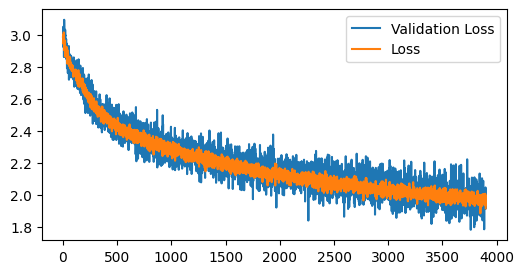

In [83]:
model = Transformer(vocab_size=vocab_size, emb_size=128, n_blocks=4, head_size=128, hidden_size=128, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 4000 # Tailored to be time-comparable to the MLP
batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [84]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")



           
KING RICHARD I+CGE in SAbigle]] brat. For hocan compertate===

Worldia ething Purch eachips] and ary theor wingual, whild nemage|Mu-ed, ''The Wackly and [[Flancime|3]] to parsition]]
Ince, her lire aniled [[Instegal Wak communic
|| '''Hapserinalo malle, 30 that racte alvo=&quot;astre-dave, howaitning of [[Splinus

# Speed
Right now we know how to build a transformer that works, but the way we implemented does not map very well to the hardware we are using. 
We will now make a bunch of improvements to the training speed that just make the code a bit more complex but keep the underlying intuition the same

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

# Transformer components
class Attention(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.qkv = nn.Linear(emb_size, 3 * emb_size, bias=False)
        self.out = nn.Linear(emb_size, emb_size, bias=False)
        self.register_buffer("mask", torch.tril(torch.ones(sequence_length, sequence_length, dtype=torch.bool)), persistent=False)

    def forward(self, x):
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        sim = (q @ k.transpose(-2, -1)) / (x.size(-1) ** 0.5)
        sim.masked_fill_(~self.mask[:x.size(1), :x.size(1)], float('-inf'))
        att = sim.softmax(-1)
        return self.out(att @ v)

class FullyConnected(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(emb_size, 4 * emb_size, bias=False),
            nn.GELU(),
            nn.Linear(4 * emb_size, emb_size, bias=False),
        )

    def forward(self, x):
        return self.fc(x)

class Block(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size)

    def forward(self, x):
        x = x + self.att(self.prenorm1(x))
        x = x + self.fc(self.prenorm2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, emb_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.blocks = nn.Sequential(*[Block(emb_size) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, vocab_size, bias=False)

    def forward(self, x):
        pos = torch.arange(x.size(1), device=x.device)
        x = self.embedding(x) + self.posemb(pos)
        x = self.blocks(x)
        x = self.norm(x)
        return self.head(x)

# Setup
model = Transformer(vocab_size, emb_size=128, n_layers=4).to(device)
model = torch.compile(model, mode="reduce-overhead")
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
batch_size = 512
steps = 3000

# Training loop
for step in range(steps):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    logits = model(inputs[indexes].to(device))
    loss = F.cross_entropy(logits.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()

    if step % (steps // 10) == 0:
        with torch.no_grad():
            model.eval()
            vi = torch.randint(0, len(val_inputs), (batch_size//4,))
            vpred = model(val_inputs[vi].to(device))
            vloss = F.cross_entropy(vpred.view(-1, vocab_size), val_labels[vi].to(device).view(-1))
            print(f"Step {step:_>4d} - Loss: {loss.item():.3f} - Val Loss: {vloss.item():.3f}")
            model.train()

# Sample generation
@torch.no_grad()
def generate(prompt, max_new=300):
    model.eval()
    idx = torch.tensor([texttoint[c] for c in prompt], dtype=torch.long).unsqueeze(0).to(device)
    for _ in range(max_new):
        logits = model(idx[:, -sequence_length:])
        next_id = torch.multinomial(logits[0, -1].softmax(-1), 1)
        idx = torch.cat([idx, next_id.view(1, 1)], dim=1)
    return ''.join([inttotext[i.item()] for i in idx[0]])

print(generate("\nKING RICHARD I", 300))


BackendCompilerFailed: backend='inductor' raised:
LoweringException: TypeError: 'NoneType' object is not callable
  target: aten.var_mean.correction
  args[0]: TensorBox(StorageBox(
    Pointwise(
      'mps',
      torch.float32,
      def inner_fn(index):
          i0, i1, i2 = index
          tmp0 = ops.load(buf1, i2 + 128 * i1 + 2560 * i0)
          tmp1 = ops.load(buf2, i2 + 128 * i1)
          tmp2 = tmp0 + tmp1
          return tmp2
      ,
      ranges=[512, 20, 128],
      origin_node=add,
      origins=OrderedSet([add])
    )
  ))
  args[1]: [2]
  kwargs: {'correction': 0, 'keepdim': True}

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


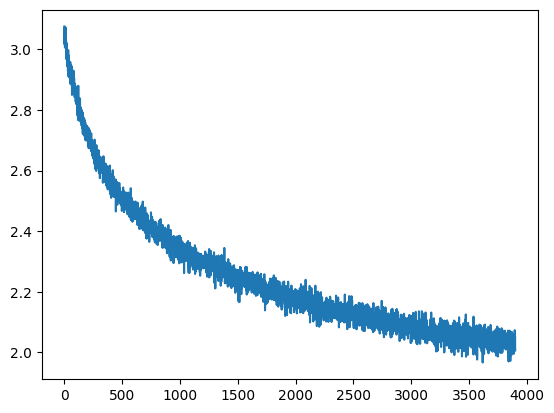

In [23]:
plt.plot(lossi[100:])